In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_recall_fscore_support
from matplotlib import pyplot as plt
from sklearn.preprocessing import binarize
import random

In [2]:
import pickle
def fmax_score(labels, predictions, beta = 1.0, pos_label = 1):
    precision, recall, thres = precision_recall_curve(labels, predictions, pos_label)
    thres = np.append([0],thres)
    f1 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
    return np.nanmax(f1), pd.DataFrame({"precision":precision,"recall":recall,"threshold":thres, "f1": f1})

In [3]:
## load trained models
measure_base = pickle.load(open("../models/inner_lr/lr_measure_9_3.pkl","rb"))
condition_base = pickle.load(open("../models/inner_lr/lr_condition_9_3.pkl","rb"))
obs_base = pickle.load(open("../models/inner_lr/lr_observation_9_3.pkl","rb"))
proc_base = pickle.load(open("../models/inner_lr/lr_procedure_9_3.pkl","rb"))
drug_base = pickle.load(open("../models/inner_lr/lr_drug_9_3.pkl","rb"))

In [4]:
## load trained ensembles
ensemble = pickle.load(open("../models/outer_lr/lr_9_3.pkl","rb"))

In [5]:
# load all data
measure_data = pd.read_csv("../eval_features/processed/measure.csv",index_col=0)
obs_data = pd.read_csv("../eval_features/processed/obs.csv",index_col=0)
condition_data = pd.read_csv("../eval_features/processed/condition.csv",index_col=0)
proc_data = pd.read_csv("../eval_features/processed/procedure.csv",index_col=0)
drug_data = pd.read_csv("../eval_features/processed/drug.csv",index_col=0)
labels = np.array(measure_data.death)

In [6]:
def random_sample_ensemble(i):
    random.seed(i)
    pos_inds = np.where(labels == 1)[0]
    neg_inds = [i for i in range(len(labels)) if i not in pos_inds]
    sampled_neg_inds = random.sample(neg_inds, len(pos_inds)*4)
    sampled_inds = np.append(pos_inds,sampled_neg_inds)
    random.shuffle(sampled_inds)
    
    ## sample data
    sample_labels = labels[sampled_inds]
    measure_features = measure_data.iloc[sampled_inds,:].drop(columns=["death"]).values
    obs_features = obs_data.iloc[sampled_inds,:].drop(columns=["death"]).values
    condition_features = condition_data.iloc[sampled_inds,:].drop(columns=["death"]).values
    proc_features = proc_data.iloc[sampled_inds,:].drop(columns=["death"]).values
    drug_features = drug_data.iloc[sampled_inds,:].drop(columns=["death"]).values
    
    ## base predictions
    measure_base_preds = measure_base.predict_proba(measure_features)[:,1]
    condition_base_preds = condition_base.predict_proba(condition_features)[:,1]
    obs_base_preds = obs_base.predict_proba(obs_features)[:,1]
    proc_base_preds = proc_base.predict_proba(proc_features)[:,1]
    drug_base_preds = drug_base.predict_proba(drug_features)[:,1]
    
    ## ensemble predictions
    base_preds = pd.DataFrame({"measure": measure_base_preds, "drug": drug_base_preds,
                                "procedure":proc_base_preds, "observation":obs_base_preds, 
                               "condition": condition_base_preds})
    base_preds = base_preds[["measure","drug","procedure","observation","condition"]]
    ensemble_preds = ensemble.predict_proba(base_preds.values)[:,1]
    
    pred_df = pd.DataFrame({"prediction":ensemble_preds , "label": sample_labels})
    pred_df.to_csv("../results/eval_preds/preds_%d.csv" %i)
    
    auc = roc_auc_score(sample_labels,ensemble_preds)
    fmax, _ = fmax_score(sample_labels, ensemble_preds)
    return pd.DataFrame({"AUC":[auc], "F-Max": fmax}, index=[i])

In [8]:
import warnings
warnings.filterwarnings('ignore')

perf_dfs = []
for i in range(1000):
    perf_dfs.append(random_sample_ensemble(i))
    if i % 100 == 0:
        print(i)
performance = pd.concat(perf_dfs)
performance

0
100
200
300
400
500
600
700
800
900


,AUC,F-Max
0,0.487115,0.333333
1,0.488715,0.342733
2,0.507487,0.341253
3,0.488281,0.335456
4,0.495795,0.340517
5,0.495470,0.342733
6,0.474067,0.336000
7,0.482015,0.333333
8,0.506158,0.343478
9,0.487440,0.336170


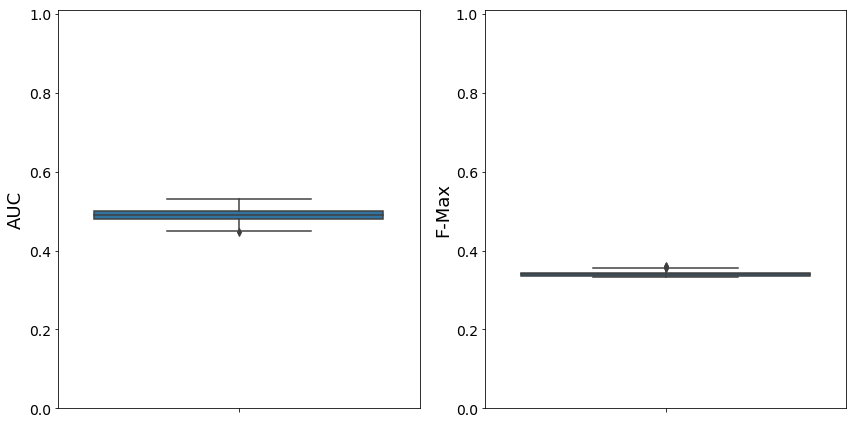

In [31]:
import seaborn as sns
f, [ax1, ax2] = plt.subplots(nrows=1,ncols=2, figsize=(12,6))

sns.boxplot(data=performance, y="AUC", ax=ax1)
sns.boxplot(data=performance, y="F-Max", ax=ax2)

ax1.set_ylim(0,1.01)
ax2.set_ylim(0,1.01)

ax1.set_ylabel("AUC", fontsize=18)
ax2.set_ylabel("F-Max", fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)


f.tight_layout()

plt.savefig("../results/ensemble_evaluation.png")

plt.show()
plt.close()

In [57]:
# pos_inds = np.where(labels == 1)[0]
# neg_inds = [i for i in range(len(labels)) if i not in pos_inds]
# print(len(pos_inds), len(neg_inds))
# import random
# random.seed(2018)
# sampled_neg_inds = random.sample(neg_inds, 96*4)
# print(len(sampled_neg_inds))
# sampled_inds = np.append(pos_inds,sampled_neg_inds)
# random.shuffle(sampled_inds)
# print(sampled_inds)

In [46]:
# measure_data = measure_data.iloc[sampled_inds,:]
# labels = labels[sampled_inds]
# measure_features = measure_data.drop(columns=["death"]).values

In [47]:
# measure_base_preds = measure_base.predict_proba(measure_features)[:,1]

In [48]:
# # observation base prediction
# obs_data = pd.read_csv("../eval_features/processed/obs.csv",index_col=0).iloc[sampled_inds,:]
# obs_features = obs_data.drop(columns=["death"]).values
# obs_base_preds = obs_base.predict_proba(obs_features)[:,1]

In [49]:
# condition base prediction
condition_data = pd.read_csv("../eval_features/processed/condition.csv",index_col=0).iloc[sampled_inds,:]
condition_features = condition_data.drop(columns=["death"]).values
condition_base_preds = condition_base.predict_proba(condition_features)[:,1]

In [50]:
# procedure base prediction
proc_data = pd.read_csv("../eval_features/processed/procedure.csv",index_col=0).iloc[sampled_inds,:]
proc_features = proc_data.drop(columns=["death"]).values
proc_base_preds = proc_base.predict_proba(proc_features)[:,1]

In [51]:
# drug base prediction
drug_data = pd.read_csv("../eval_features/processed/drug.csv",index_col=0).iloc[sampled_inds,:]
drug_features = drug_data.drop(columns=["death"]).values
drug_base_preds = drug_base.predict_proba(drug_features)[:,1]

In [52]:
# ensemble predictions
base_preds = pd.DataFrame({"measure": measure_base_preds, "drug": drug_base_preds,
                                "procedure":proc_base_preds, "observation":obs_base_preds, 
                               "condition": condition_base_preds})
base_preds = base_preds[["measure","drug","procedure","observation","condition"]]
ensemble_preds = ensemble.predict_proba(base_preds.values)[:,1]
ensemble_preds

array([0.14064706, 0.43629019, 0.48175147, 0.19625617, 0.11570647,
       0.27809594, 0.17903033, 0.14010031, 0.42047871, 0.21411202,
       0.22314833, 0.15848669, 0.14312696, 0.11289417, 0.39873323,
       0.23123472, 0.199896  , 0.29800465, 0.16375537, 0.14954152,
       0.41183344, 0.4080137 , 0.17337913, 0.20244218, 0.11215555,
       0.14264937, 0.44925953, 0.40032028, 0.13022403, 0.27751267,
       0.19641812, 0.1757448 , 0.39479103, 0.22388998, 0.13948956,
       0.30207391, 0.45089588, 0.34975859, 0.31521982, 0.12219879,
       0.13255005, 0.43372782, 0.18106623, 0.15435113, 0.17941828,
       0.13403839, 0.4492466 , 0.4219412 , 0.16228849, 0.1243708 ,
       0.14488659, 0.15610813, 0.18894858, 0.19376044, 0.22304831,
       0.40028189, 0.4179603 , 0.17465167, 0.4199756 , 0.12870389,
       0.12952399, 0.39999134, 0.26338497, 0.51820179, 0.21274553,
       0.13175193, 0.42942546, 0.16585975, 0.21762977, 0.18254328,
       0.41846524, 0.17596421, 0.43312424, 0.13807178, 0.20816

In [37]:
len(ensemble_preds) == len(labels)

True

In [53]:
roc_auc_score(labels,ensemble_preds)

0.5404459635416666

In [54]:
fmax,perf_df = fmax_score(labels, obs_base_preds,pos_label=1)

/Users/Alex/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [55]:
fmax

0.34645669291338577

Text(0.5, 1.0, '2-class Precision-Recall curve')

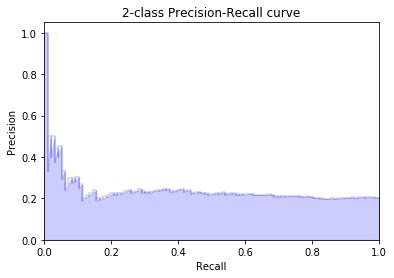

In [56]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(labels, ensemble_preds)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

In [44]:
perf_df.loc[perf_df.f1==fmax,:]

,f1,precision,recall,threshold
16,0.336918,0.203463,0.979167,0.009163


In [51]:
perf_df.shape

(14715, 3)

In [74]:
97/20000

0.00485